# Carwash
Covers:

- Waiting for other processes

- Resources: Resource

The Carwash example is a simulation of a carwash with a limited number of machines and a number of cars that arrive at the carwash to get cleaned.

The carwash uses a Resource to model the limited number of washing machines. It also defines a process for washing a car.

When a car arrives at the carwash, it requests a machine. Once it got one, it starts the carwash’s wash processes and waits for it to finish. It finally releases the machine and leaves.

The cars are generated by a setup process. After creating an initial amount of cars it creates new car processes after a random time interval as long as the simulation continues.

"""

In [1]:
"""
Carwash example.

Covers:

- Waiting for other processes
- Resources: Resource

Scenario:
  A carwash has a limited number of washing machines and defines
  a washing processes that takes some (random) time.

  Car processes arrive at the carwash at a random time. If one washing
  machine is available, they start the washing process and wait for it
  to finish. If not, they wait until they can use one.

"""

import itertools
import random

import simpy

# fmt: off
RANDOM_SEED = 42
NUM_MACHINES = 1  # Number of machines in the carwash ###############################################
WASHTIME = 5      # Minutes it takes to clean a car
T_INTER = 7       # Create a car every ~7 minutes
SIM_TIME = 20     # Simulation time in minutes
# fmt: on

##########################################################################################
stats = {}
stats['cars'] = []
stats['waittimes'] = []
stats['totaltimes'] = []
##########################################################################################

class Carwash:
    """A carwash has a limited number of machines (``NUM_MACHINES``) to
    clean cars in parallel.

    Cars have to request one of the machines. When they got one, they
    can start the washing processes and wait for it to finish (which
    takes ``washtime`` minutes).

    """

    def __init__(self, env, num_machines, washtime):
        self.env = env
        self.machine = simpy.Resource(env, num_machines)
        self.washtime = washtime

    def wash(self, car):
        """The washing processes. It takes a ``car`` processes and tries
        to clean it."""
        yield self.env.timeout(self.washtime)
        pct_dirt = random.randint(50, 99)
        print(f"Carwash removed {pct_dirt}% of {car}'s dirt.")


def car(env, name, cw):
    """The car process (each car has a ``name``) arrives at the carwash
    (``cw``) and requests a cleaning machine.

    It then starts the washing process, waits for it to finish and
    leaves to never come back ...

    """

    stats['cars'].append(name) ###########################################################
    print(f'{name} arrives at the carwash at {env.now:.2f}.')
    
    arrival_time = env.now #################################################################
    
    with cw.machine.request() as request:
        yield request

        print(f'{name} enters the carwash at {env.now:.2f}.')
        
        enter_time = env.now ################################################################
        
        yield env.process(cw.wash(name))

        print(f'{name} leaves the carwash at {env.now:.2f}.')
        leave_time = env.now ###############################################################
        
    stats['waittimes'].append(enter_time - arrival_time)  ##################################
    stats['totaltimes'].append(leave_time - arrival_time) ##################################

def setup(env, num_machines, washtime, t_inter):
    """Create a carwash, a number of initial cars and keep creating cars
    approx. every ``t_inter`` minutes."""
    # Create the carwash
    carwash = Carwash(env, num_machines, washtime)

    car_count = itertools.count()

    # Create 4 initial cars
    for _ in range(4):
        env.process(car(env, f'Car {next(car_count)}', carwash))

    # Create more cars while the simulation is running
    while True:
        yield env.timeout(random.randint(t_inter - 2, t_inter + 2))
        env.process(car(env, f'Car {next(car_count)}', carwash))


# Setup and start the simulation
print('Carwash')
print('Check out http://youtu.be/fXXmeP9TvBg while simulating ... ;-)')
random.seed(RANDOM_SEED)  # This helps to reproduce the results

# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, NUM_MACHINES, WASHTIME, T_INTER))

# Execute!
env.run(until=SIM_TIME)

Carwash
Check out http://youtu.be/fXXmeP9TvBg while simulating ... ;-)
Car 0 arrives at the carwash at 0.00.
Car 1 arrives at the carwash at 0.00.
Car 2 arrives at the carwash at 0.00.
Car 3 arrives at the carwash at 0.00.
Car 0 enters the carwash at 0.00.
Car 4 arrives at the carwash at 5.00.
Carwash removed 97% of Car 0's dirt.
Car 0 leaves the carwash at 5.00.
Car 1 enters the carwash at 5.00.
Car 5 arrives at the carwash at 10.00.
Carwash removed 65% of Car 1's dirt.
Car 1 leaves the carwash at 10.00.
Car 2 enters the carwash at 10.00.
Carwash removed 64% of Car 2's dirt.
Car 2 leaves the carwash at 15.00.
Car 3 enters the carwash at 15.00.
Car 6 arrives at the carwash at 17.00.


In [2]:
print(f"stats {stats}")

stats {'cars': ['Car 0', 'Car 1', 'Car 2', 'Car 3', 'Car 4', 'Car 5', 'Car 6'], 'waittimes': [0, 5, 10], 'totaltimes': [5, 10, 15]}


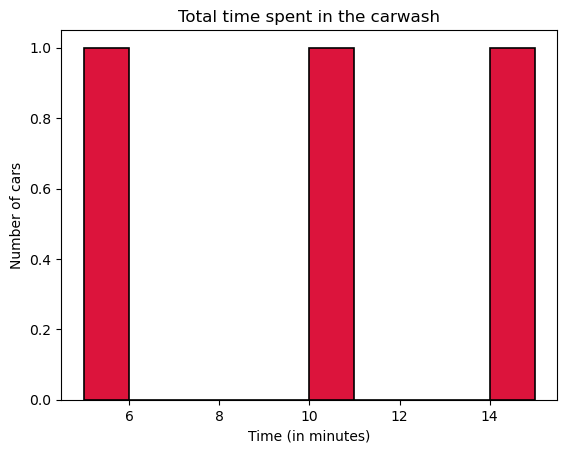

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()

plt.hist(stats['totaltimes'], color='crimson', edgecolor='black', linewidth=1.2)
plt.xlabel('Time (in minutes)')
plt.title('Total time spent in the carwash')
plt.ylabel('Number of cars')
plt.show()
